In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('/Users/taddbackus/School/fall23/qtw/cs5/log2.csv')
print(df)

       Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
0            57222                53            54587                    53   
1            56258              3389            56258                  3389   
2             6881             50321            43265                 50321   
3            50553              3389            50553                  3389   
4            50002               443            45848                   443   
...            ...               ...              ...                   ...   
65527        63691                80            13237                    80   
65528        50964                80            13485                    80   
65529        54871               445                0                     0   
65530        54870               445                0                     0   
65531        54867               445                0                     0   

      Action    Bytes  Bytes Sent  Bytes Received  

In [3]:
df.isna().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [4]:
for column in df.columns:
    unique_values = len(df[column].unique())
    print(column,'=',unique_values)

Source Port = 22724
Destination Port = 3273
NAT Source Port = 29152
NAT Destination Port = 2533
Action = 4
Bytes = 10724
Bytes Sent = 6683
Bytes Received = 8814
Packets = 1116
Elapsed Time (sec) = 915
pkts_sent = 749
pkts_received = 922


In [5]:
print(df['Action'].value_counts())

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64


allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64


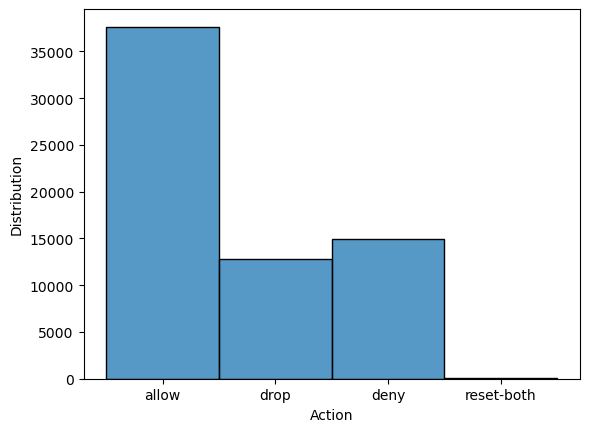

In [6]:
print(df['Action'].value_counts())
sns.histplot(data=df, x='Action')
plt.xlabel('Action')
plt.ylabel('Distribution')
plt.show()

In [7]:
columns_to_encode = ['Source Port','Destination Port','NAT Source Port','NAT Destination Port']
df_encode = pd.get_dummies(df, columns=columns_to_encode,prefix=columns_to_encode)


In [8]:
X = df_encode.drop(columns=['Action'])
y = df_encode['Action']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [13]:
cValues = [0.001, 0.01, 0.1, 1, 10, 100]
for c in cValues:
    svmModel = LinearSVC(dual=True,C=c)
    svmModel.fit(X_train,y_train)
    svmPred = svmModel.predict(X_test)
    print('=============================')
    print('C',c)
    print(classification_report(y_test,svmPred))
    print(confusion_matrix(y_test,svmPred))
    print('=============================')

C 0.001
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7511
        deny       0.99      1.00      1.00      3032
        drop       1.00      1.00      1.00      2552
  reset-both       0.00      0.00      0.00        12

    accuracy                           1.00     13107
   macro avg       0.75      0.75      0.75     13107
weighted avg       1.00      1.00      1.00     13107

[[7499   12    0    0]
 [   1 3025    6    0]
 [   0    0 2552    0]
 [   2   10    0    0]]
C 0.01
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7511
        deny       0.99      1.00      1.00      3032
        drop       1.00      1.00      1.00      2552
  reset-both       0.00      0.00      0.00        12

    accuracy                           1.00     13107
   macro avg       0.75      0.75      0.75     13107
weighted avg       1.00      1.00      1.00     13107

[[7501   10    0    0]

In [9]:
svmModel = LinearSVC(dual=True,class_weight='balanced',C=10)

In [10]:
svmModel.fit(X_train,y_train)
svmPred = svmModel.predict(X_test)
svmAcc = accuracy_score(y_test, svmPred)
print('SVM Accuracy:', svmAcc)

SVM Accuracy: 0.998092622262913


In [11]:
labels = df['Action'].unique()
print(labels)

['allow' 'drop' 'deny' 'reset-both']


In [12]:
confMatrix = confusion_matrix(y_test,svmPred)
print(classification_report(y_test,svmPred))

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7525
        deny       1.00      1.00      1.00      3072
        drop       1.00      1.00      1.00      2501
  reset-both       0.00      0.00      0.00         9

    accuracy                           1.00     13107
   macro avg       0.75      0.75      0.75     13107
weighted avg       1.00      1.00      1.00     13107



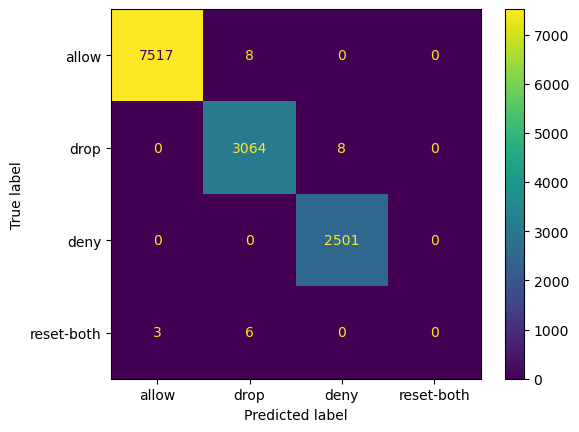

In [13]:
disp = ConfusionMatrixDisplay(confusion_matrix=confMatrix,display_labels=labels)
disp.plot()
plt.show()

In [15]:
sgdModel = SGDClassifier(early_stopping=True, loss='log_loss',class_weight='balanced')

In [16]:
sgdModel.fit(X_train,y_train)
sgdPred = sgdModel.predict(X_test)
print(classification_report(y_test,sgdPred))
sgdConfMatrix = confusion_matrix(y_test,sgdPred)

              precision    recall  f1-score   support

       allow       0.57      1.00      0.73      7525
        deny       0.00      0.00      0.00      3072
        drop       0.00      0.00      0.00      2501
  reset-both       0.00      0.00      0.00         9

    accuracy                           0.57     13107
   macro avg       0.14      0.25      0.18     13107
weighted avg       0.33      0.57      0.42     13107



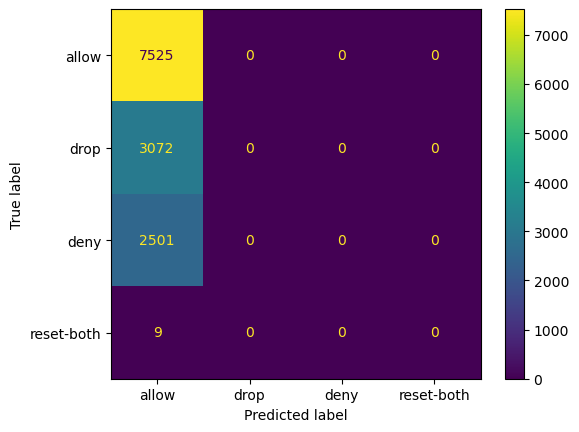

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=sgdConfMatrix,display_labels=labels)
disp.plot()
plt.show()

In [31]:
# bvreaks my compyuter
#cross_val_score(sgdModel,X,y,verbose=True,n_jobs=-1,cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


KeyboardInterrupt: 